# **Importing Libraries and Downloading the Dataset from Kaggle**


In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
!pip install hiddenlayer
import hiddenlayer

In [2]:
!pip install -q kaggle
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d spandan2/cats-faces-64x64-for-generative-models

 92% 88.0M/96.0M [00:00<00:00, 84.4MB/s]
100% 96.0M/96.0M [00:01<00:00, 73.7MB/s]


In [4]:
!mkdir cat
!unzip "/content/cats-faces-64x64-for-generative-models.zip" -d '/content/cat'

Streaming output truncated to the last 5000 lines.
  inflating: /content/cat/cats/cats/5499.jpg  
  inflating: /content/cat/cats/cats/55.jpg  
  inflating: /content/cat/cats/cats/550.jpg  
  inflating: /content/cat/cats/cats/5500.jpg  
  inflating: /content/cat/cats/cats/5501.jpg  
  inflating: /content/cat/cats/cats/5502.jpg  
  inflating: /content/cat/cats/cats/5503.jpg  
  inflating: /content/cat/cats/cats/5504.jpg  
  inflating: /content/cat/cats/cats/5505.jpg  
  inflating: /content/cat/cats/cats/5506.jpg  
  inflating: /content/cat/cats/cats/5507.jpg  
  inflating: /content/cat/cats/cats/5508.jpg  
  inflating: /content/cat/cats/cats/5509.jpg  
  inflating: /content/cat/cats/cats/551.jpg  
  inflating: /content/cat/cats/cats/5510.jpg  
  inflating: /content/cat/cats/cats/5511.jpg  
  inflating: /content/cat/cats/cats/5512.jpg  
  inflating: /content/cat/cats/cats/5513.jpg  
  inflating: /content/cat/cats/cats/5514.jpg  
  inflating: /content/cat/cats/cats/5515.jpg  
  inflating: 

In [5]:
dataset = torchvision.datasets.ImageFolder(root='/content/cat/cats',transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,),std=(0.5,))]))
dataloader = torch.utils.data.DataLoader(dataset=dataset,batch_size=16,shuffle=True)

# **Building Discriminator and Generator Model**

In [6]:
class Discriminator(nn.Module):
    
    def __init__(self,channels=3):
        super(Discriminator,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=channels,out_channels=64,kernel_size=4,stride=2,padding=1)
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1)
        self.bnm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1)
        self.bnm3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=2,padding=1)
        self.bnm4 = nn.BatchNorm2d(512)
        self.final = nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,stride=2,padding=0)
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()

    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m], 0.0, 0.02)


    def forward(self,x):
        x = self.conv1(x) 
        x = self.leakyrelu(x)      
        x = self.conv2(x)
        x = self.bnm2(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.bnm3(x)
        x = self.leakyrelu(x)        
        x = self.conv4(x)
        x = self.bnm4(x)
        x = self.leakyrelu(x)        
        x = self.final(x)
        x = self.flatten(self.sigmoid(x))
        return x

In [7]:
class Generator(nn.Module):

    def __init__(self,noise=100,channels=3):
        super(Generator,self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels=noise,out_channels=1024,kernel_size=4,stride=1,padding=0)
        self.bnm1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=4,stride=2,padding=1)
        self.bnm2 = nn.BatchNorm2d(512)
        self.conv3 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=4,stride=2,padding=1)
        self.bnm3 = nn.BatchNorm2d(256)
        self.conv4 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=4,stride=2,padding=1)      
        self.bnm4 = nn.BatchNorm2d(128)      
        self.conv5 = nn.ConvTranspose2d(in_channels=128,out_channels=channels,kernel_size=4,stride=2,padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m], 0.0, 0.02)

    def forward(self,x):
        x = self.conv1(x)
        x = self.bnm1(x)
        x = self.relu(x)        
        x = self.conv2(x)
        x = self.bnm2(x)
        x = self.relu(x)        
        x = self.conv3(x)
        x = self.bnm3(x)
        x = self.relu(x)        
        x = self.conv4(x)
        x = self.bnm4(x)
        x = self.relu(x)        
        x = self.conv5(x)
        x = self.tanh(x)
        return x 

# **Setting up the hyperparameters and Visualizing the Models**



In [8]:
epochs = 50
lr =  0.0002
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 16

disc = Discriminator().to(device)
gen = Generator().to(device)

criterion = nn.BCELoss()
opt_disc = torch.optim.Adam(params=disc.parameters(),lr=lr,betas=(0.5,0.999))
opt_gen = torch.optim.Adam(params=gen.parameters(),lr=lr,betas=(0.5,0.999))

In [9]:
print(summary(model=gen,input_size=(100,1,1)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,639,424
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,389,120
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,408
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,416
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           6,147
             Tanh-14            [-1, 3,

In [10]:
print(summary(model=disc,input_size=(3,64,64)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,200
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,544
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,664
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,193
          Sigmoid-13              [-1, 1, 1, 1]               0
          Flatten-14                   

# **Training Begins Here!**

In [12]:
gen.train()
disc.train()

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bnm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bnm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bnm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (final): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  (leakyrelu): LeakyReLU(negative_slope=0.2)
  (sigmoid): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [13]:
fixed_noise = torch.randn(16, 100, 1, 1).to(device)

In [14]:
for epoch in range(0,epochs):
  for batch_index , (real_images,_) in enumerate(dataloader):
    real_images = real_images.to(device)
    batch_size = real_images.shape[0]

    # Training the Discriminator
    noise = torch.randn(batch_size,100,1,1).to(device)
    fake_images = gen(noise)
    disc_real_images = disc(real_images).view(-1)
    loss_real_images = criterion(disc_real_images,torch.ones_like(disc_real_images))
    disc_fake_images = disc(fake_images)
    loss_fake_images = criterion(disc_fake_images,torch.zeros_like(disc_fake_images))
    lossD = loss_real_images + loss_fake_images
    disc.zero_grad()
    lossD.backward(retain_graph=True)
    opt_disc.step()

    #Training the Generator
    result = disc(fake_images)
    lossG = criterion(result,torch.ones_like(result))
    gen.zero_grad()
    lossG.backward(retain_graph=True)
    opt_gen.step()
    if batch_index % 100 == 0:
      print(f"Epoch {epoch+1}/{epochs} Batch {batch_index+1}/{len(dataloader)} Loss D: {lossD:.4f}, loss G: {lossG:.4f}")

Epoch 1/50 Batch 1/985 Loss D: 1.4315, loss G: 3.8951
Epoch 1/50 Batch 101/985 Loss D: 0.4236, loss G: 8.5796
Epoch 1/50 Batch 201/985 Loss D: 0.9345, loss G: 2.6708
Epoch 1/50 Batch 301/985 Loss D: 1.1273, loss G: 1.6852
Epoch 1/50 Batch 401/985 Loss D: 0.8313, loss G: 2.6244
Epoch 1/50 Batch 501/985 Loss D: 1.2493, loss G: 5.3810
Epoch 1/50 Batch 601/985 Loss D: 0.6579, loss G: 3.6015
Epoch 1/50 Batch 701/985 Loss D: 0.5208, loss G: 2.6498
Epoch 1/50 Batch 801/985 Loss D: 0.5415, loss G: 2.5261
Epoch 1/50 Batch 901/985 Loss D: 0.7170, loss G: 3.8588
Epoch 2/50 Batch 1/985 Loss D: 0.4480, loss G: 3.1534
Epoch 2/50 Batch 101/985 Loss D: 0.1205, loss G: 3.5863
Epoch 2/50 Batch 201/985 Loss D: 0.8729, loss G: 3.2859
Epoch 2/50 Batch 301/985 Loss D: 1.4250, loss G: 3.8093
Epoch 2/50 Batch 401/985 Loss D: 0.0890, loss G: 5.4422
Epoch 2/50 Batch 501/985 Loss D: 0.2544, loss G: 4.2467
Epoch 2/50 Batch 601/985 Loss D: 0.2023, loss G: 6.2891
Epoch 2/50 Batch 701/985 Loss D: 0.2438, loss G: 3.1

# **Testing GANs!!**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


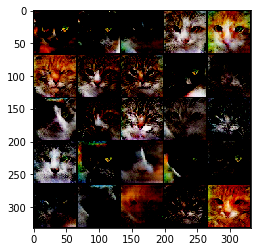

In [15]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

noise = torch.randn(25,100,1,1)
generated_images = gen(noise.to(device))
generated_images = generated_images.cpu()
grid = torchvision.utils.make_grid(generated_images, nrow=5)
show(grid)